<a href="https://colab.research.google.com/github/alanrbtx/dl_lab1/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# https://www.kaggle.com/discussions/general/74235
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/stanford-cars-dataset
! unzip -q stanford-cars-dataset.zip -d stanford-cars-dataset

100% 1.82G/1.82G [01:25<00:00, 20.6MB/s]
100% 1.82G/1.82G [01:25<00:00, 22.8MB/s]


In [3]:
! mkdir annotations

In [4]:
! wget -P annotations/ https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_meta.mat
! wget -P annotations/ https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_train_annos.mat
! wget -P annotations/ https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_test_annos_withlabels_eval.mat

--2023-11-11 19:41:38--  https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_meta.mat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alanrbtx/dl_lab1/main/annotations/cars_meta.mat [following]
--2023-11-11 19:41:39--  https://raw.githubusercontent.com/alanrbtx/dl_lab1/main/annotations/cars_meta.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3177 (3.1K) [application/octet-stream]
Saving to: ‘annotations/cars_meta.mat’

cars_meta.mat       100%[===================>]   3.10K  --.-KB/s    in 0s      

2023-11-11 19:41:39 (63.6 MB/s) - ‘annotations/cars_meta.mat’ saved [3177/3177]

# Custom Dataset

In [28]:
from torch.utils.data import Dataset, DataLoader
from typing import Callable
from scipy.io import loadmat
from PIL import Image
import os
class CarsDataset(Dataset):
    def __init__(self, imgs_dir: str, annos_path: str, transforms: Callable = None):
        self.imgs_paths = self.__load_imgs_paths(imgs_dir)
        self.labels = self.__load_labels(annos_path)
        self.transforms = transforms

    def __load_imgs_paths(self, dir):
        return [os.path.join(dir, filename) for filename in os.listdir(dir) if os.path.isfile(os.path.join(dir, filename))]

    def __load_labels(self, path):
        mat = loadmat(path)
        labels = {}

        for arr in mat['annotations'][0]:
            filename, label = str(arr[5][0]), int(arr[4][0,0])-1
            labels[filename] = label

        return labels

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, index):
        img_path = self.imgs_paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[os.path.basename(img_path)]

        if self.transforms:
            img = self.transforms(img)

        return img, label

In [29]:
def load_class_names(path):
    return [str(arr[0]) for arr in loadmat(path)['class_names'][0]]

In [30]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Resize((227, 227)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [31]:
train_dataset = CarsDataset(imgs_dir = './stanford-cars-dataset/cars_train/cars_train',
                            annos_path = './annotations/cars_train_annos.mat',
                            transforms = transforms)
test_dataset = CarsDataset(imgs_dir = './stanford-cars-dataset/cars_test/cars_test',
                           annos_path ='./annotations/cars_test_annos_withlabels_eval.mat',
                           transforms = transforms)

In [32]:
class_names = load_class_names('./annotations/cars_meta.mat')
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=True)

# Train and test loops

In [22]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
from tqdm import tqdm

def train_one_epoch(model: torch.nn.Module, loader: DataLoader, optimizer, loss_fn):
    running_loss = 0.

    # training mode
    model.train(True)

    for i, data in enumerate(tqdm(loader)):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # обнуление градиентов
        optimizer.zero_grad()

        # предсказание
        outputs = model(inputs)

        # считаем ошибку и градиенты
        loss = loss_fn(outputs, labels)
        loss.backward()

        # обновление весов
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

In [24]:
! pip install torcheval

In [25]:
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

def validate(model, loader, loss_fn):
    running_vloss = 0.0
    pred_labels_ids = torch.Tensor().type(torch.int64)
    true_labels_ids = torch.Tensor().type(torch.int64)

    # evaluation mode
    model.eval()

    # disable gradient computation
    with torch.no_grad():
        for i, vdata in enumerate(loader):
            vinputs, vlabels = vdata

            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            running_vloss += vloss.item()
            true_labels_ids = torch.cat((true_labels_ids, vlabels.cpu().squeeze()))
            pred_labels_ids = torch.cat((pred_labels_ids, voutputs.cpu().argmax(dim=-1, keepdim=False)))

    # compute loss and metrics
    avg_vloss = running_vloss / len(loader)
    accuracy = multiclass_accuracy(pred_labels_ids, true_labels_ids)
    f1 = multiclass_f1_score(pred_labels_ids, true_labels_ids, num_classes=len(class_names), average='weighted')
    f1_macro = multiclass_f1_score(pred_labels_ids, true_labels_ids, num_classes=len(class_names), average='macro')

    return avg_vloss, accuracy.detach().numpy(), f1.detach().numpy(), f1_macro.detach().numpy()

In [26]:
def train_loop(model, train_loader, test_loader, optimizer, loss_fn, prefix, epochs=10):
    best_vloss = 1e10

    history = {'Train loss': [], 'Valid loss': [], 'Accuracy': [], 'F1': [], 'F1 macro': []}

    for epoch_number in range(epochs):
        print(f'\nEpoch {epoch_number+1}:')

        avg_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        avg_vloss, accuracy, f1, f1_macro = validate(model, test_loader, loss_fn)

        print('\n\U0001f600 LOSS train: {} valid {}'.format(avg_loss, avg_vloss))
        print('Accuracy:', accuracy)
        print('F1:', f1)
        print('F1 macro:', f1_macro)

        history['Train loss'].append(avg_loss)
        history['Valid loss'].append(avg_vloss)
        history['Accuracy'].append(accuracy)
        history['F1'].append(f1)
        history['F1 macro'].append(f1_macro)

        # save best model
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = f'{prefix}_{epoch_number+1}'
            torch.save(model.state_dict(), model_path)

    return history

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history['Train loss'])
    plt.plot(history['Valid loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history['Accuracy'])
    plt.plot(history['F1'])
    plt.plot(history['F1 macro'])
    plt.title('metrics')
    plt.ylabel('metrics')
    plt.xlabel('epoch')
    plt.legend(['Accuracy', 'F1', 'F1 macro'], loc='upper left')
    plt.show()

# Model

In [16]:
import torch

class AlexNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_stack = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, kernel_size=11, stride=4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            torch.nn.Conv2d(96, 256, 5, stride=1, padding=2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            torch.nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.flatten = torch.nn.Flatten()

        self.classification_head = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(9216, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.classification_head(x)
        return x

# Training

In [17]:
! pip install balanced-loss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [33]:
import pandas as pd

samples_per_class = pd.Series(train_dataset.labels).value_counts().sort_index().tolist()


Epoch 1:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 5.280332267284393 valid 5.276725679636002
Accuracy: 0.0057206815
F1: 6.508009e-05
F1 macro: 5.8042257e-05

Epoch 2:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 5.277740776538849 valid 5.2759696543216705
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 3:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 5.26857316493988 valid 5.218382835388184
Accuracy: 0.011565725
F1: 0.00047808734
F1 macro: 0.0004081789

Epoch 4:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 5.214040279388428 valid 5.185589581727982
Accuracy: 0.011938813
F1: 0.00060472806
F1 macro: 0.00051119353

Epoch 5:


100%|██████████| 16/16 [01:00<00:00,  3.76s/it]



😀 LOSS train: 5.170330464839935 valid 5.159267961978912
Accuracy: 0.0125606265
F1: 0.0004626342
F1 macro: 0.0003803499

Epoch 6:


100%|██████████| 16/16 [01:00<00:00,  3.78s/it]



😀 LOSS train: 5.14306703209877 valid 5.131403684616089
Accuracy: 0.014177341
F1: 0.001317276
F1 macro: 0.0011769248

Epoch 7:


100%|██████████| 16/16 [01:00<00:00,  3.76s/it]



😀 LOSS train: 5.113386750221252 valid 5.122477889060974
Accuracy: 0.0139286155
F1: 0.0020311554
F1 macro: 0.0019160513

Epoch 8:


100%|██████████| 16/16 [01:00<00:00,  3.78s/it]



😀 LOSS train: 5.100814938545227 valid 5.109651058912277
Accuracy: 0.012809352
F1: 0.0021922383
F1 macro: 0.0020581367

Epoch 9:


100%|██████████| 16/16 [01:00<00:00,  3.78s/it]



😀 LOSS train: 5.082237333059311 valid 5.112556457519531
Accuracy: 0.014426067
F1: 0.0034963978
F1 macro: 0.0033222395

Epoch 10:


100%|██████████| 16/16 [01:00<00:00,  3.76s/it]



😀 LOSS train: 5.057146310806274 valid 5.100285738706589
Accuracy: 0.014923517
F1: 0.0030601262
F1 macro: 0.0028821337

Epoch 11:


100%|██████████| 16/16 [01:00<00:00,  3.76s/it]



😀 LOSS train: 5.030057519674301 valid 5.100136458873749
Accuracy: 0.015669692
F1: 0.0051874137
F1 macro: 0.0051192977

Epoch 12:


100%|██████████| 16/16 [01:00<00:00,  3.76s/it]



😀 LOSS train: 4.985563695430756 valid 5.088286101818085
Accuracy: 0.024126353
F1: 0.01126262
F1 macro: 0.011344305

Epoch 13:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 4.9292672872543335 valid 5.086665749549866
Accuracy: 0.019649297
F1: 0.010895676
F1 macro: 0.010931718

Epoch 14:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 4.8561020493507385 valid 5.074541002511978
Accuracy: 0.027608506
F1: 0.015047825
F1 macro: 0.0153339915

Epoch 15:


100%|██████████| 16/16 [01:00<00:00,  3.79s/it]



😀 LOSS train: 4.776316523551941 valid 5.139794081449509
Accuracy: 0.02313145
F1: 0.018601866
F1 macro: 0.018539768

Epoch 16:


100%|██████████| 16/16 [01:00<00:00,  3.79s/it]



😀 LOSS train: 4.683424711227417 valid 5.174530565738678
Accuracy: 0.032583013
F1: 0.023883663
F1 macro: 0.024156364

Epoch 17:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 4.5357299745082855 valid 5.206059962511063
Accuracy: 0.030593209
F1: 0.023973003
F1 macro: 0.024533685

Epoch 18:


100%|██████████| 16/16 [01:00<00:00,  3.77s/it]



😀 LOSS train: 4.329489916563034 valid 5.315490782260895
Accuracy: 0.034075364
F1: 0.025463626
F1 macro: 0.025630742

Epoch 19:


100%|██████████| 16/16 [01:00<00:00,  3.80s/it]



😀 LOSS train: 4.091868624091148 valid 5.409950941801071
Accuracy: 0.03531899
F1: 0.02750602
F1 macro: 0.02824787

Epoch 20:


100%|██████████| 16/16 [01:00<00:00,  3.78s/it]



😀 LOSS train: 3.8370350301265717 valid 5.74139529466629
Accuracy: 0.035940804
F1: 0.031524252
F1 macro: 0.032265354


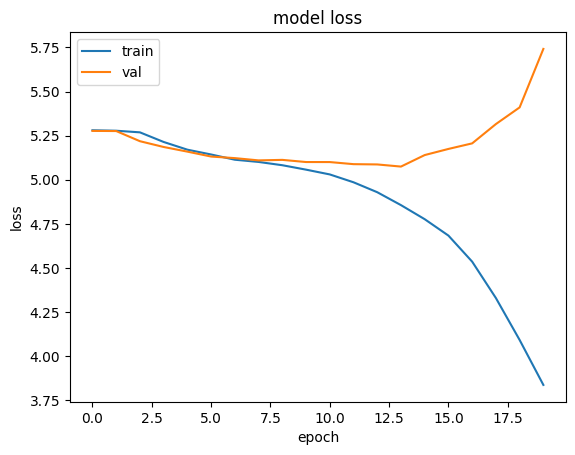

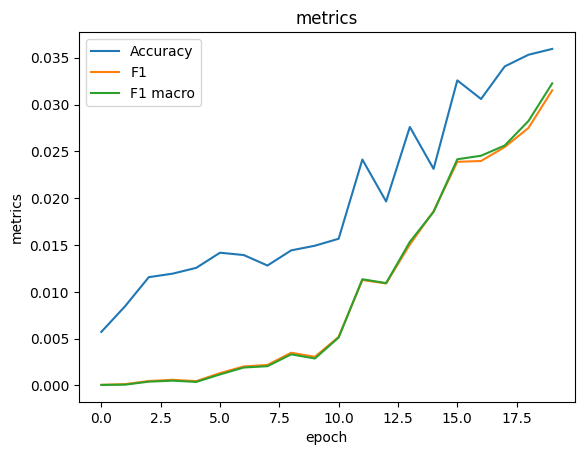

In [34]:
from balanced_loss import Loss

model = AlexNet(len(class_names)).to(device)
# balanced_ce = Loss(loss_type="cross_entropy",
#                    samples_per_class=samples_per_class,
#                    class_balanced=True)
ce = torch.nn.CrossEntropyLoss()
adam = torch.optim.Adam(model.parameters(), lr=0.0005)
history = train_loop(model, train_loader, test_loader, adam, ce, 'alexnet', 20)
plot_history(history)